In [9]:
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import LSTM, Dense
from datetime import datetime
from dateutil.relativedelta import relativedelta
from pandas_datareader import data as pdr
import yfinance as yf

yf.pdr_override()

In [10]:
now = datetime.now()

before = now - relativedelta(years=10)

now_day = now.strftime("%Y-%m-%d")
befor_day = before.strftime("%Y-%m-%d")
print(f"end : {now_day}")
print(f"start: {befor_day}")
samsung_stock = pdr.get_data_yahoo("005930.KS", start= befor_day, end = now_day)
print(samsung_stock)

end : 2022-12-01
start: 2012-12-01
[*********************100%***********************]  1 of 1 completed
               Open     High      Low    Close     Adj Close    Volume
Date                                                                  
2012-12-03  28400.0  28720.0  28160.0  28600.0  22883.531250  10220850
2012-12-04  28640.0  28680.0  28400.0  28600.0  22883.531250   9504900
2012-12-05  28600.0  29100.0  28540.0  29100.0  23283.593750  12436400
2012-12-06  29360.0  29420.0  28680.0  29080.0  23267.583984  14248700
2012-12-07  29000.0  29960.0  29000.0  29600.0  23683.652344  15882450
...             ...      ...      ...      ...           ...       ...
2022-11-24  61200.0  61700.0  60900.0  61400.0  61400.000000   8125010
2022-11-25  61400.0  61700.0  60800.0  61000.0  61000.000000   6677933
2022-11-28  60500.0  60500.0  59800.0  60100.0  60100.000000   8589032
2022-11-29  59900.0  60600.0  59800.0  60600.0  60600.000000   7014160
2022-11-30  60400.0  62200.0  60200.0  62200

In [11]:
close_prices = samsung_stock["Close"].values
print(close_prices)

windown_size = 30

result_list = []
for i in range(len(close_prices) - (windown_size + 1)):
    result_list.append(close_prices[i: i + (windown_size + 1)])

normal_data = []
for window in result_list :
    window_list = [((float(p) / float(window[0])) - 1) for p in window]
    normal_data.append(window_list)
    
result_list = np.array(normal_data)
print(result_list.shape[0],result_list.shape[1])

[28600. 28600. 29100. ... 60100. 60600. 62200.]
2424 31


In [15]:
row = int(round(result_list.shape[0] * 0.9))
train = result_list[:row, :]

x_train = train[:, :-1]
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
y_train = train[:, -1]

x_test = result_list[row:, :-1]
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
y_test = result_list[row:, -1]

x_train.shape, x_test.shape

((2182, 30, 1), (242, 30, 1))

In [16]:
model = Sequential()
model.add(LSTM(windown_size, return_sequences=True, input_shape=(windown_size,1)))
model.add(LSTM(64, return_sequences=False))
model.add(Dense(1, activation="linear"))
model.compile(loss ="mse", optimizer="rmsprop")
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_5 (LSTM)               (None, 30, 30)            3840      
                                                                 
 lstm_6 (LSTM)               (None, 64)                24320     
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 28,225
Trainable params: 28,225
Non-trainable params: 0
_________________________________________________________________


In [17]:
model.fit(x_train, y_train, validation_data = (x_test, y_test), batch_size=10, epochs=10)

model.save(r"C:\Users\user\Desktop\40가지 프로그램 만들기\39. 삼성전자의 주식 예측하기\samsung.h5")

Epoch 1/10
219/219 [==============================] - 6s 17ms/step - loss: 0.0016 - val_loss: 6.3404e-04
Epoch 2/10
219/219 [==============================] - 3s 14ms/step - loss: 9.3245e-04 - val_loss: 7.7312e-04
Epoch 3/10
219/219 [==============================] - 3s 15ms/step - loss: 8.0779e-04 - val_loss: 3.6510e-04
Epoch 4/10
219/219 [==============================] - 3s 13ms/step - loss: 7.3007e-04 - val_loss: 0.0012
Epoch 5/10
219/219 [==============================] - 3s 13ms/step - loss: 6.8975e-04 - val_loss: 3.4917e-04
Epoch 6/10
219/219 [==============================] - 3s 13ms/step - loss: 6.3389e-04 - val_loss: 3.0530e-04
Epoch 7/10
219/219 [==============================] - 3s 13ms/step - loss: 6.0428e-04 - val_loss: 3.9016e-04
Epoch 8/10
219/219 [==============================] - 3s 13ms/step - loss: 5.7451e-04 - val_loss: 2.9255e-04
Epoch 9/10
219/219 [==============================] - 3s 14ms/step - loss: 5.5945e-04 - val_loss: 2.9793e-04
Epoch 10/10
219/219 [======

8/8 [==============================] - 0s 9ms/step


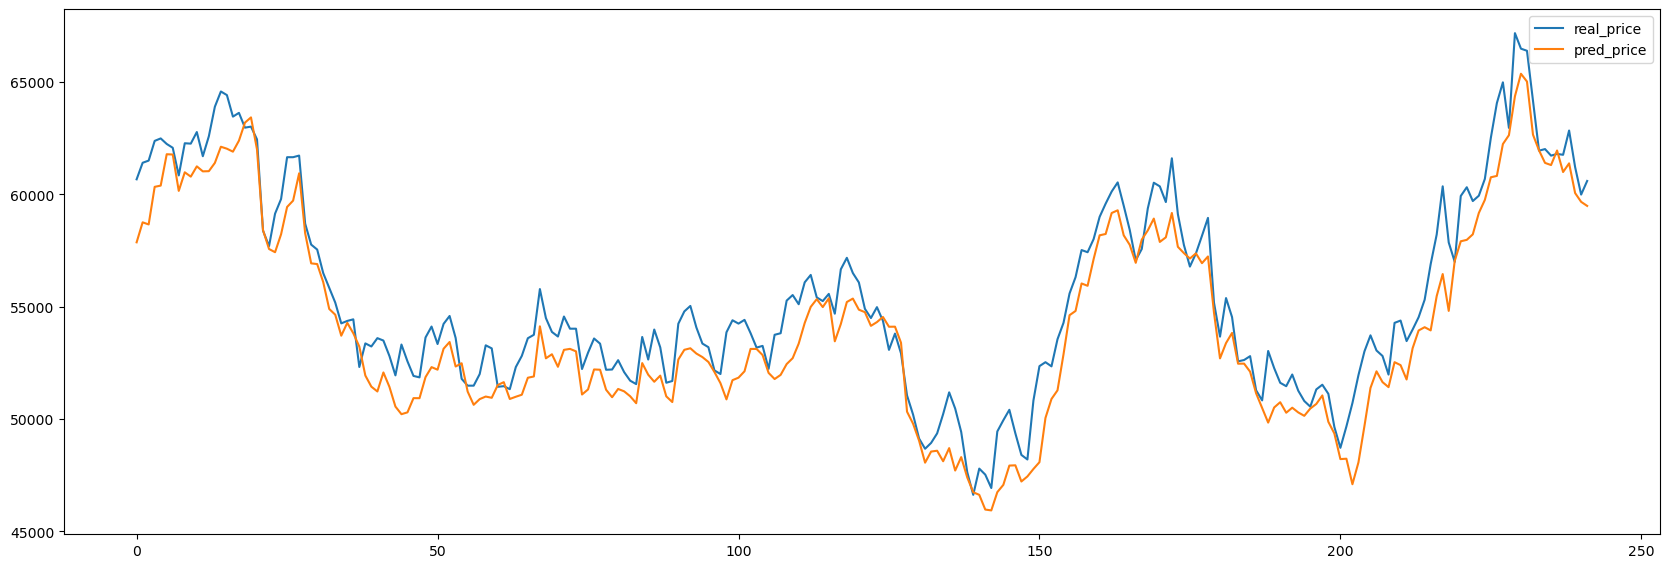

In [19]:
pred = model.predict(x_test)

pred_price = []
for i in pred :
    pred_price.append( (i + 1) * window[0])
    
real_price = []
for i in y_test :
    real_price.append( (i + 1) * window[0])

fig = plt.figure(facecolor="white", figsize = (70, 15))
ax = fig.add_subplot(234)
ax.plot(real_price, label="real_price")
ax.plot(pred_price, label="pred_price")
ax.legend()
plt.show()